# Gesture Recognition Assignment
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

In [1]:
## Checking the GPU configuration

!nvidia-smi

Fri May 31 17:41:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                Off | 00000000:1E:00.0 Off |                  Off |
| 34%   36C    P8              17W / 260W |      6MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [3]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())


## Plotting Function to reduce iterative use of code

 Define a plotting function to avoid using same code multiple times

In [6]:
import cv2
import matplotlib.pyplot as plt

# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print('Source path =', source_path, '; batch size =', batch_size)
    img_idx = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]  # List of image numbers
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 3))  # Batch data array
            batch_labels = np.zeros((batch_size, 5))  # Batch labels array
            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # Sort to ensure consistent ordering
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0  # Normalize and add to batch data
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encode labels
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining data points
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_data_points, 5))
            for folder in range(remaining_data_points):
                folder_name = t[num_batches * batch_size + folder].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.layers import Dropout

#write your model here


## Experiment Model A

Dimension : 100 * 100, Batch Size : 51 and using 18 images from each video frames

In [10]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(18, 100, 100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2024-06-03 20:44:53.343082: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-03 20:44:53.343151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [11]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 64)     0

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# Learning rate reduction
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='auto',
    min_lr=0.00001
)


callbacks_list = [checkpoint, LR]


In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 51
Epoch 1/20


2024-06-03 20:45:10.276433: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


13/13 [==============================] - ETA: 0s - loss: 1.6968 - categorical_accuracy: 0.4208Source path = /home/datasets/Project_data/val ; batch size = 51

Epoch 00001: saving model to model_init_2024-06-0320_44_49.715766/model-00001-1.69680-0.42081-1.59507-0.18000.h5
13/13 [==============================] - 91s 7s/step - loss: 1.6968 - categorical_accuracy: 0.4208 - val_loss: 1.5951 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 1.0038 - categorical_accuracy: 0.6139
Epoch 00002: saving model to model_init_2024-06-0320_44_49.715766/model-00002-1.00383-0.61388-1.68934-0.32000.h5
13/13 [==============================] - 89s 7s/step - loss: 1.0038 - categorical_accuracy: 0.6139 - val_loss: 1.6893 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.5963 - categorical_accuracy: 0.7813 
Epoch 00004: saving model to model_init_2024-06-0320_44_49.715766/mode

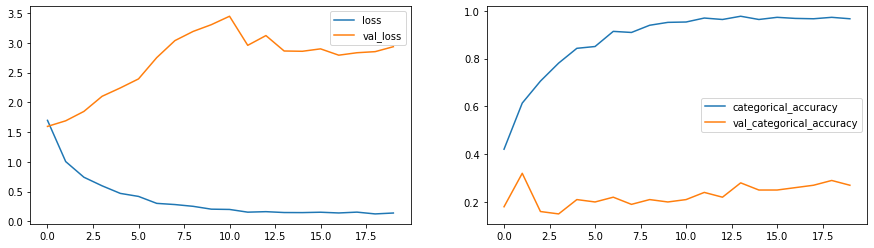

In [17]:
plot(model1)

It appears that the model is overfitting.
Also, The validation loss is increasing significantly indicating that the model is not generalizing well to unseen data.

## Experiment Model B

Lets change batch size to 30 and introduce early stopping and add regularization to the model (like L2 or dropout).

In [18]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(18, 100, 100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

new_batch_size = 20
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,  # Reduce the patience to 5
    verbose=1,
    mode='auto',
    min_lr=0.00001
)

callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 100, 100, 32)  2624      
                                                                 
 activation_3 (Activation)   (None, 18, 100, 100, 32)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 18, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 50, 50, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 9, 50, 50, 64)    

In [21]:
num_epochs2=20
#now i will also save the model to plot graphs
model2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 5.3393 - categorical_accuracy: 0.3077Source path = /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-06-0320_44_49.715766/model-00001-5.33926-0.30769-5.05610-0.22500.h5
13/13 [==============================] - 38s 3s/step - loss: 5.3393 - categorical_accuracy: 0.3077 - val_loss: 5.0561 - val_categorical_accuracy: 0.2250 - lr: 0.0100
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 4.9531 - categorical_accuracy: 0.4885
Epoch 00002: saving model to model_init_2024-06-0320_44_49.715766/model-00002-4.95312-0.48846-4.96436-0.32500.h5
13/13 [==============================] - 36s 3s/step - loss: 4.9531 - categorical_accuracy: 0.4885 - val_loss: 4.9644 - val_categorical_accuracy: 0.3250 - lr: 0.0100
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 4.7184 - categorical_accuracy: 0

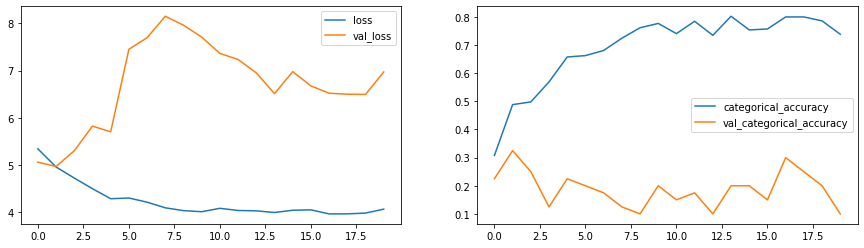

In [23]:
plot(model2)

We can see improvements

## Experiment Model C

Lets decrease parameters and train with batch size 15

In [24]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
         input_shape=(18, 100, 100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

new_batch_size = 15
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,  # Reduce the patience to 5
    verbose=1,
    mode='auto',
    min_lr=0.00001
)

callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 100, 100, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 18, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 9, 50, 50, 32)    

In [26]:
num_epochs2=20

model3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 5.3951 - categorical_accuracy: 0.2872Source path = /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-06-0320_44_49.715766/model-00001-5.39508-0.28718-7.14057-0.20000.h5
13/13 [==============================] - 28s 2s/step - loss: 5.3951 - categorical_accuracy: 0.2872 - val_loss: 7.1406 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 5.1037 - categorical_accuracy: 0.3538
Epoch 00002: saving model to model_init_2024-06-0320_44_49.715766/model-00002-5.10372-0.35385-7.20980-0.13333.h5
13/13 [==============================] - 27s 2s/step - loss: 5.1037 - categorical_accuracy: 0.3538 - val_loss: 7.2098 - val_categorical_accuracy: 0.1333 - lr: 0.0100
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 4.8158 - categorical_accuracy: 0

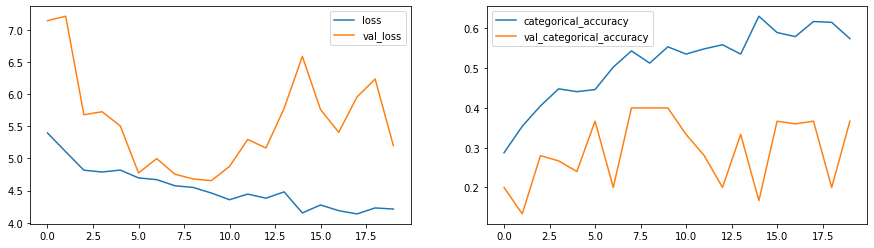

In [27]:
plot(model3)


The validation accuracy is improved in the previous model. Now we can experiment by training the further.
### But now we have got an understanding of the impacts of increasing Batch Size and adding early stopping and parameters so let us start creating models with these changes and batch size.

## Model 1

Dimension : 100 * 100, Batch Size : 30 and using 18 images from each video frames

In [10]:
model = Sequential()
        
model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(18, 100, 100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2024-05-31 17:41:12.707569: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-31 17:41:12.707625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
batch_size = 30
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Learning rate reduction
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
)

callbacks_list = [checkpoint, LR]


The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20


2024-05-30 20:34:25.447036: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.9089 - categorical_accuracy: 0.3017Source path = /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-05-3020_33_44.943120/model-00001-1.90891-0.30166-3.25670-0.18000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.9089 - categorical_accuracy: 0.3017 - val_loss: 3.2567 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5970 - categorical_accuracy: 0.3891
Epoch 00002: saving model to model_init_2024-05-3020_33_44.943120/model-00002-1.59701-0.38914-1.55910-0.31000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.5970 - categorical_accuracy: 0.3891 - val_loss: 1.5591 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.2874 - categorical_accuracy: 0.4917
Epoch 00003: saving model to model_init_2024-05-3020_33_44.943120/model

In [16]:
print("Total Params:", model.count_params())

Total Params: 892101


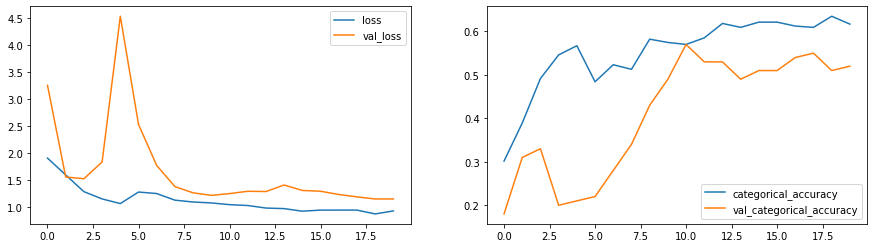

In [17]:
plot(history)

## Model 2

Lets decrease the batch size and make Epoch to 30

In [18]:
new_batch_size = 20
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 32)     0

In [19]:
num_epochs2=30
#now i will also save the model to plot graphs
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.0453 - categorical_accuracy: 0.5696Source path = /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-05-3020_33_44.943120/model-00001-1.04533-0.56957-1.17188-0.51250.h5
23/23 [==============================] - 61s 3s/step - loss: 1.0453 - categorical_accuracy: 0.5696 - val_loss: 1.1719 - val_categorical_accuracy: 0.5125 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1339 - categorical_accuracy: 0.5621
Epoch 00002: saving model to model_init_2024-05-3020_33_44.943120/model-00002-1.13387-0.56208-1.72131-0.42500.h5
23/23 [==============================] - 59s 3s/step - loss: 1.1339 - categorical_accuracy: 0.5621 - val_loss: 1.7213 - val_categorical_accuracy: 0.4250 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1498 - categorical_accuracy: 0

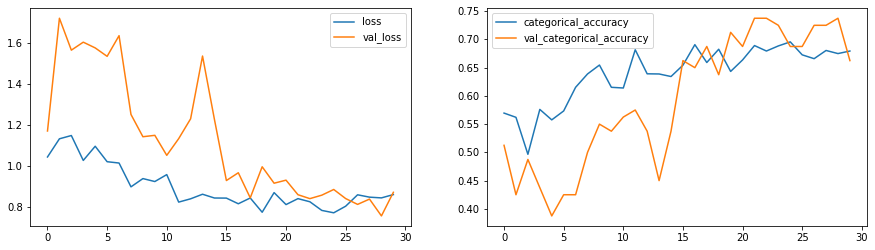

In [20]:
plot(history2)

## Model 3

Lets increase the batch size and make Epoch to 25

In [22]:
new_batch_size = 50
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 32)     0

In [23]:
num_epochs2=25
#now i will also save the model to plot graphs
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 50
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 0.7174 - categorical_accuracy: 0.7170Source path = /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-05-3020_33_44.943120/model-00001-0.71745-0.71698-1.06231-0.59000.h5
23/23 [==============================] - 147s 7s/step - loss: 0.7174 - categorical_accuracy: 0.7170 - val_loss: 1.0623 - val_categorical_accuracy: 0.5900 - lr: 0.0100
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 0.6490 - categorical_accuracy: 0.7584
Epoch 00002: saving model to model_init_2024-05-3020_33_44.943120/model-00002-0.64898-0.75836-0.78892-0.71500.h5
23/23 [==============================] - 143s 6s/step - loss: 0.6490 - categorical_accuracy: 0.7584 - val_loss: 0.7889 - val_categorical_accuracy: 0.7150 - lr: 0.0100
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 0.6247 - categorical_accuracy:

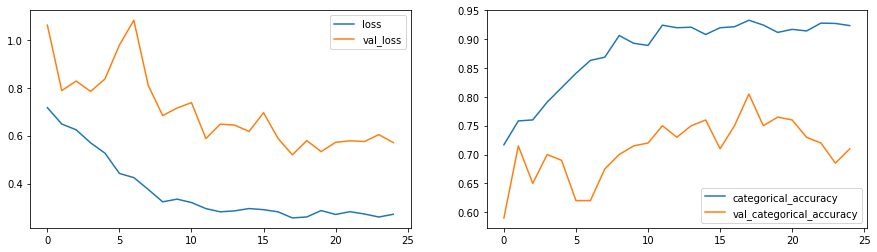

In [24]:
plot(history3)

Again Increasing Batch size also increased total training time as seen in Experiment Model A as well and also previous model on increasing batch size is not satisfactory.

## Model 4

Lets change the optmiser from SGD to Adam and batch size to 10

In [28]:
new_batch_size = 10
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 32)     0

In [29]:
num_epochs2=20
#now i will also save the model to plot graphs
history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.8409 - categorical_accuracy: 0.6783
Epoch 00001: saving model to model_init_2024-05-3020_33_44.943120/model-00001-0.84087-0.67826-17.06649-0.12727.h5
23/23 [==============================] - 35s 2s/step - loss: 0.8409 - categorical_accuracy: 0.6783 - val_loss: 17.0665 - val_categorical_accuracy: 0.1273 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.1796 - categorical_accuracy: 0.5609
Epoch 00002: saving model to model_init_2024-05-3020_33_44.943120/model-00002-1.17962-0.56087-6.95371-0.34545.h5
23/23 [==============================] - 36s 2s/step - loss: 1.1796 - categorical_accuracy: 0.5609 - val_loss: 6.9537 - val_categorical_accuracy: 0.3455 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.9059 - categorical_accuracy: 0.6682
Epoch 00003: saving model to model_init_2024-05-3020_33_

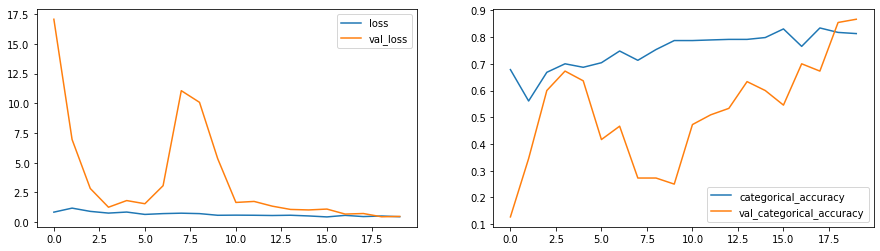

In [30]:
plot(history4)

## Model 5
Change batch size to 15 keeping optmiser as Adam

In [31]:
new_batch_size = 15
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 32)     0

In [32]:
num_epochs2=20
#now i will also save the model to plot graphs
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.5279 - categorical_accuracy: 0.8029Source path = /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3020_33_44.943120/model-00001-0.52789-0.80290-0.69501-0.68333.h5
23/23 [==============================] - 89s 4s/step - loss: 0.5279 - categorical_accuracy: 0.8029 - val_loss: 0.6950 - val_categorical_accuracy: 0.6833 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.5433 - categorical_accuracy: 0.7958
Epoch 00002: saving model to model_init_2024-05-3020_33_44.943120/model-00002-0.54329-0.79580-8.50919-0.16364.h5
23/23 [==============================] - 82s 4s/step - loss: 0.5433 - categorical_accuracy: 0.7958 - val_loss: 8.5092 - val_categorical_accuracy: 0.1636 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.4637 - categorical_accuracy: 0

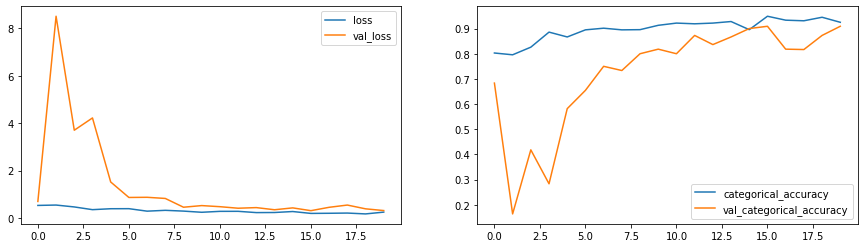

In [34]:
plot(history5)

## Model 6

As we saw the validation accuracy is increased in the previous model and can be improved with higher number of epochs. Now we can experiment if we can get better results by improving the image resolution. Previously we tried with the 100 * 100 image resolution. Now we will use 120 * 120 image resolution and we will use 15 batch size.

In [35]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3))  # Batch data array
            batch_labels = np.zeros((batch_size, 5))  # Batch labels array
            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # Sort to ensure consistent ordering
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (120, 120))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0  # Normalize and add to batch data
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encode labels
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining data points
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((remaining_data_points, 5))
            for folder in range(remaining_data_points):
                folder_name = t[num_batches * batch_size + folder].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (120, 120))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [36]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(18, 120, 120, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [38]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_32 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 9, 60, 60, 32)    

In [39]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [40]:
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20


2024-05-31 07:46:52.738804: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.5224 - categorical_accuracy: 0.4344Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3107_46_18.674085/model-00001-1.52242-0.43439-5.63782-0.19000.h5
45/45 [==============================] - 179s 4s/step - loss: 1.5224 - categorical_accuracy: 0.4344 - val_loss: 5.6378 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.0820 - categorical_accuracy: 0.5822
Epoch 00002: saving model to model_init_2024-05-3107_46_18.674085/model-00002-1.08197-0.58220-6.37046-0.20000.h5
45/45 [==============================] - 149s 3s/step - loss: 1.0820 - categorical_accuracy: 0.5822 - val_loss: 6.3705 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.8639 - categorical_accuracy: 0.6908
Epoch 00003: saving model to model_init_2024-05-3107_46_18.674085/mo

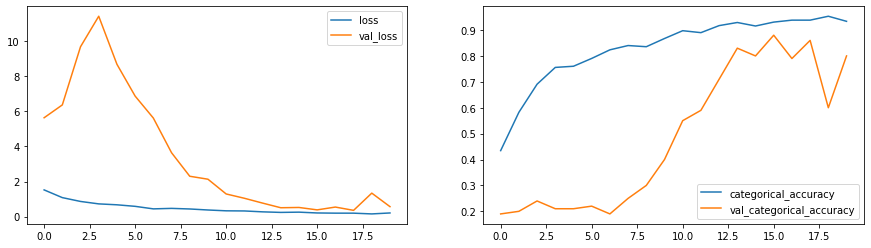

In [41]:
plot(history6)

The validation accuracy is dropping and not constant compared to previous results.

## Model 7
Reduce filter size to (2,2,2) and Batch Size = 15 and adjust dense_neurons No. of Epochs = 25

In [46]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
        input_shape=(18, 120, 120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

In [47]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 18, 120, 120, 16)  400       
                                                                 
 activation_32 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 9, 60, 60, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 9, 60, 60, 32)    

In [48]:
num_epochs = 20
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [49]:
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.6526 - categorical_accuracy: 0.4419Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3107_46_18.674085/model-00001-1.65265-0.44193-5.69545-0.21000.h5
45/45 [==============================] - 91s 2s/step - loss: 1.6526 - categorical_accuracy: 0.4419 - val_loss: 5.6955 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.0357 - categorical_accuracy: 0.6305
Epoch 00002: saving model to model_init_2024-05-3107_46_18.674085/model-00002-1.03566-0.63047-8.50937-0.18000.h5
45/45 [==============================] - 164s 4s/step - loss: 1.0357 - categorical_accuracy: 0.6305 - val_loss: 8.5094 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.8962 - categorical_accuracy

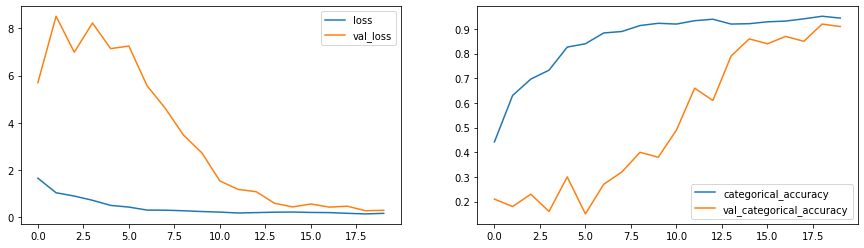

In [50]:
plot(history7)

## Model 8
Adjust filter size further and Reduce dense_neurons & dropout


In [51]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(18, 120, 120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))



In [52]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_50 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_37 (Activation)  (None, 9, 60, 60, 32)    

In [53]:
num_epochs = 20
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [54]:
history8 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.3717 - categorical_accuracy: 0.4751Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3107_46_18.674085/model-00001-1.37171-0.47511-3.89481-0.22000.h5
45/45 [==============================] - 86s 2s/step - loss: 1.3717 - categorical_accuracy: 0.4751 - val_loss: 3.8948 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.7458 - categorical_accuracy: 0.7285
Epoch 00002: saving model to model_init_2024-05-3107_46_18.674085/model-00002-0.74585-0.72851-6.06792-0.19000.h5
45/45 [==============================] - 85s 2s/step - loss: 0.7458 - categorical_accuracy: 0.7285 - val_loss: 6.0679 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.7639 - categorical_accuracy:

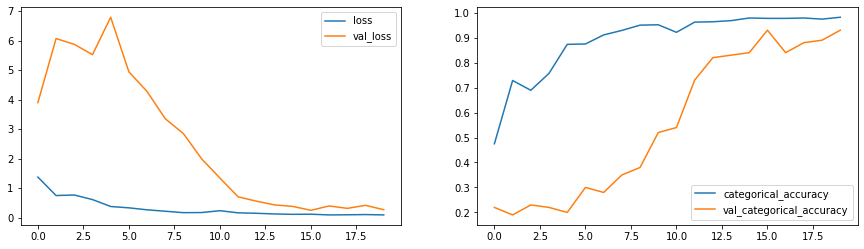

In [55]:
plot(history8)

## Model 9 - CNN- LSTM Model

Now we will try to implement the CNN + LSTM model and will compare the results with the above model which had highest validation accuracy. Batch Size is 15

In [56]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 3))  # Batch data array
            batch_labels = np.zeros((batch_size, 5))  # Batch labels array
            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # Sort to ensure consistent ordering
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0  # Normalize and add to batch data
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encode labels
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining data points
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_data_points, 5))
            for folder in range(remaining_data_points):
                folder_name = t[num_batches * batch_size + folder].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.layers.recurrent import LSTM

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(18, 100, 100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [58]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_542 (TimeD  (None, 18, 100, 100, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_543 (TimeD  (None, 18, 100, 100, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_544 (TimeD  (None, 18, 50, 50, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_545 (TimeD  (None, 18, 50, 50, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_546 (TimeD  (None, 18, 50, 50, 32) 

In [59]:
num_epochs = 25
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [60]:
history9 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/25


2024-05-31 10:17:43.366590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.5870 - categorical_accuracy: 0.2474Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3110_02_17.915360/model-00001-1.58703-0.24736-1.68453-0.21000.h5
45/45 [==============================] - 93s 2s/step - loss: 1.5870 - categorical_accuracy: 0.2474 - val_loss: 1.6845 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.4054 - categorical_accuracy: 0.4163
Epoch 00002: saving model to model_init_2024-05-3110_02_17.915360/model-00002-1.40541-0.41629-1.82136-0.17000.h5
45/45 [==============================] - 87s 2s/step - loss: 1.4054 - categorical_accuracy: 0.4163 - val_loss: 1.8214 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.1912 - categorical_accuracy: 0.5023
Epoch 00003: saving model to model_init_2024-05-3110_02_17.915360/mode

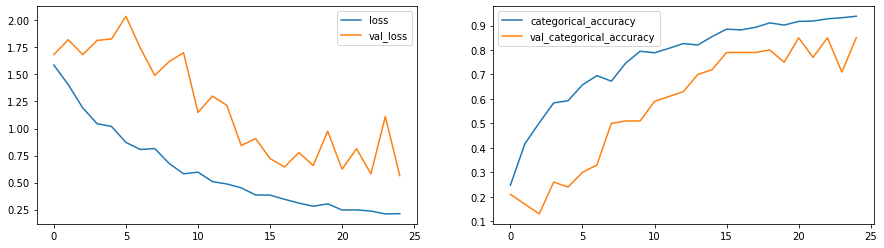

In [61]:
plot(history9)

## Model 10 

Lets try to reduce the parameters

In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.layers.recurrent import LSTM

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(18, 100, 100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [64]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_555 (TimeD  (None, 18, 100, 100, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_556 (TimeD  (None, 18, 100, 100, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_557 (TimeD  (None, 18, 50, 50, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_558 (TimeD  (None, 18, 50, 50, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_559 (TimeD  (None, 18, 50, 50, 32) 

In [65]:
num_epochs = 25
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [66]:
history10 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.5282 - categorical_accuracy: 0.2986Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3110_02_17.915360/model-00001-1.52824-0.29864-1.62102-0.21000.h5
45/45 [==============================] - 92s 2s/step - loss: 1.5282 - categorical_accuracy: 0.2986 - val_loss: 1.6210 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.2669 - categorical_accuracy: 0.4676
Epoch 00002: saving model to model_init_2024-05-3110_02_17.915360/model-00002-1.26687-0.46757-1.80996-0.20000.h5
45/45 [==============================] - 88s 2s/step - loss: 1.2669 - categorical_accuracy: 0.4676 - val_loss: 1.8100 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.1789 - categorical_accuracy:

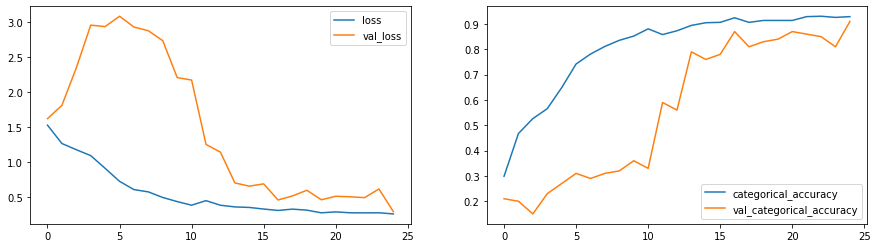

In [67]:
plot(history10)

## Model 11 

Change Dimensions to 120 * 120

In [68]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3))  # Batch data array
            batch_labels = np.zeros((batch_size, 5))  # Batch labels array
            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # Sort to ensure consistent ordering
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (120, 120))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0  # Normalize and add to batch data
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encode labels
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining data points
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((remaining_data_points, 5))
            for folder in range(remaining_data_points):
                folder_name = t[num_batches * batch_size + folder].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (120, 120))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [69]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(18, 120, 120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(5, activation='softmax'))

In [70]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_67 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 18, 60, 60, 32)  

In [71]:
num_epochs = 25
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [72]:
history11 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/25


2024-05-31 13:36:07.103427: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 4.7382 - categorical_accuracy: 0.2278Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3113_29_51.408011/model-00001-4.73821-0.22775-3.44920-0.21000.h5
45/45 [==============================] - 98s 2s/step - loss: 4.7382 - categorical_accuracy: 0.2278 - val_loss: 3.4492 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 2.7503 - categorical_accuracy: 0.3635
Epoch 00002: saving model to model_init_2024-05-3113_29_51.408011/model-00002-2.75034-0.36350-2.63628-0.12000.h5
45/45 [==============================] - 90s 2s/step - loss: 2.7503 - categorical_accuracy: 0.3635 - val_loss: 2.6363 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 2.0870 - categorical_accuracy: 0.4646
Epoch 00003: saving model to model_init_2024-05-3113_29_51.408011/mode

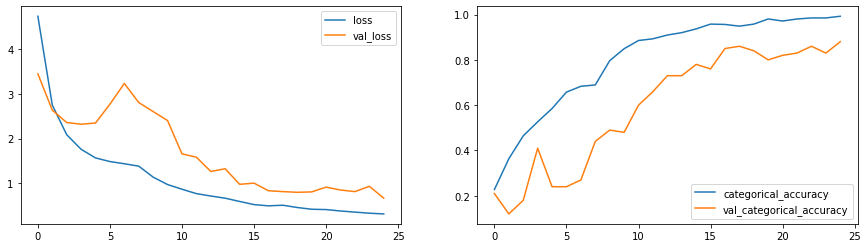

In [73]:
plot(history11)

## Model 12 
Lets Try GRU

In [78]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(18, 120, 120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64,kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [79]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_118 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_120 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_121 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, 18, 60, 60, 32)  

In [80]:
num_epochs = 25
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [81]:
history12 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 4.0154 - categorical_accuracy: 0.4419Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3113_29_51.408011/model-00001-4.01535-0.44193-4.00479-0.21000.h5
45/45 [==============================] - 91s 2s/step - loss: 4.0154 - categorical_accuracy: 0.4419 - val_loss: 4.0048 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 2.6459 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2024-05-3113_29_51.408011/model-00002-2.64589-0.58824-3.34470-0.22000.h5
45/45 [==============================] - 88s 2s/step - loss: 2.6459 - categorical_accuracy: 0.5882 - val_loss: 3.3447 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 2.2207 - categorical_accuracy:

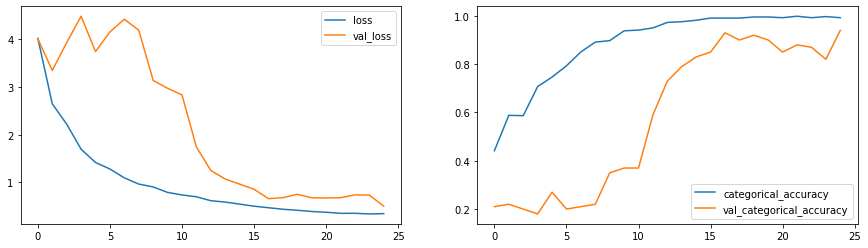

In [82]:
plot(history12)

## Model 13

Train more

In [88]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_118 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_120 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_121 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, 18, 60, 60, 32)  

In [90]:
num_epochs=20
#now i will also save the model to plot graphs
history13 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 0.1437 - categorical_accuracy: 1.0000Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3113_29_51.408011/model-00001-0.14366-1.00000-0.50007-0.92000.h5
45/45 [==============================] - 87s 2s/step - loss: 0.1437 - categorical_accuracy: 1.0000 - val_loss: 0.5001 - val_categorical_accuracy: 0.9200 - lr: 2.0000e-04
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.1418 - categorical_accuracy: 0.9985
Epoch 00002: saving model to model_init_2024-05-3113_29_51.408011/model-00002-0.14184-0.99849-0.41579-0.93000.h5
45/45 [==============================] - 90s 2s/step - loss: 0.1418 - categorical_accuracy: 0.9985 - val_loss: 0.4158 - val_categorical_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.1794 - categorical_accuracy: 0.9879
Epoch 00003: saving model to model_init_2024-05-311

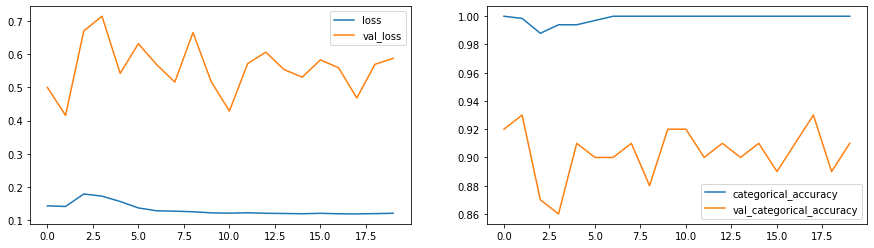

In [91]:
plot(history13)

## Model 14
Try with 100 * 100 dimension

In [92]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 3))  # Batch data array
            batch_labels = np.zeros((batch_size, 5))  # Batch labels array
            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # Sort to ensure consistent ordering
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0  # Normalize and add to batch data
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encode labels
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining data points
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_data_points, 5))
            for folder in range(remaining_data_points):
                folder_name = t[num_batches * batch_size + folder].split(';')[0]
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, folder_name, imgs[item])).astype(np.float32)
                    
                    image_resized = resize(image, (100, 100))
                    
                    batch_data[folder, idx, :, :, :] = image_resized / 255.0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [93]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
        input_shape=(18, 100, 100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64,kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [94]:
new_batch_size = 15
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 18, 100, 100, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 100, 100, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 18, 50, 50, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 18, 50, 50, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 18, 50, 50, 16)  

In [95]:
num_epochs = 25
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [96]:
#now i will also save the model to plot graphs
history14 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 3.3041 - categorical_accuracy: 0.3786Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2024-05-3117_41_09.281495/model-00001-3.30412-0.37858-3.45277-0.21000.h5
45/45 [==============================] - 90s 2s/step - loss: 3.3041 - categorical_accuracy: 0.3786 - val_loss: 3.4528 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 2.4588 - categorical_accuracy: 0.5219
Epoch 00002: saving model to model_init_2024-05-3117_41_09.281495/model-00002-2.45883-0.52187-3.30130-0.21000.h5
45/45 [==============================] - 87s 2s/step - loss: 2.4588 - categorical_accuracy: 0.5219 - val_loss: 3.3013 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.9064 - categorical_accuracy:

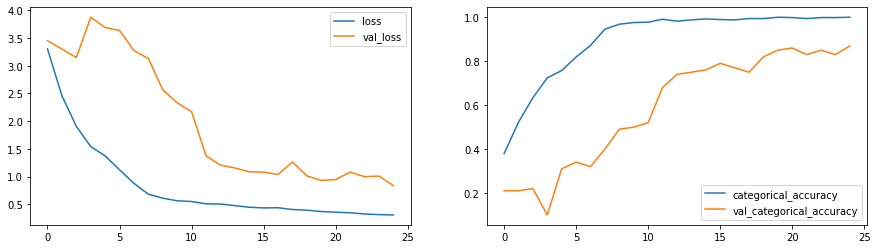

In [97]:
plot(history14)

## Model 15
Try training more

In [98]:
num_epochs = 30

#now i will also save the model to plot graphs
history15 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 0.3066 - categorical_accuracy: 1.0000
Epoch 00001: saving model to model_init_2024-05-3117_41_09.281495/model-00001-0.30660-1.00000-0.71293-0.86000.h5
45/45 [==============================] - 88s 2s/step - loss: 0.3066 - categorical_accuracy: 1.0000 - val_loss: 0.7129 - val_categorical_accuracy: 0.8600 - lr: 4.0000e-05
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 0.3025 - categorical_accuracy: 0.9985
Epoch 00002: saving model to model_init_2024-05-3117_41_09.281495/model-00002-0.30247-0.99849-0.93356-0.82000.h5
45/45 [==============================] - 89s 2s/step - loss: 0.3025 - categorical_accuracy: 0.9985 - val_loss: 0.9336 - val_categorical_accuracy: 0.8200 - lr: 4.0000e-05
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 0.2992 - categorical_accuracy: 1.0000
Epoch 00003: saving model to model_init_2024-05-3117_41_09.281495/model-00003-0.29918-1.00000-0.87988-0.83000.h5
45/

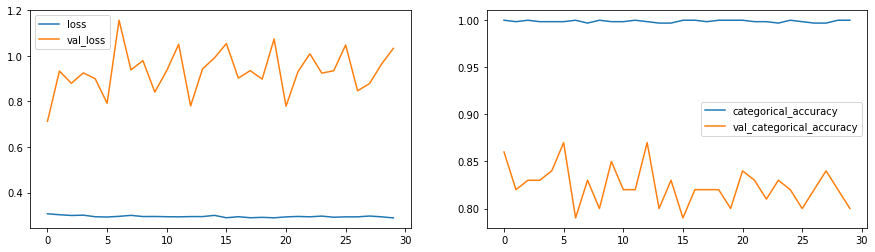

In [99]:
plot(history15)